# Learning sensorimotor models

In the [last tutorial](http://nbviewer.ipython.org/github/flowersteam/explauto/blob/master/notebook/setting_environments.ipynb) we have seen how to set up environments in Explauto, allowing to compute the sensory effects of given motor commands. Here we present another essential building block of the library: the [sensorimotor_model package](http://flowersteam.github.io/explauto/explauto.sensorimotormodel.html).

As explained in the [Explauto introduction](http://flowersteam.github.io/explauto/about.html), an important challenge in Developmental Robotics is how robots can efficiently learn sensorimotor mappings by experience, i.e. the mappings between the motor actions they make and the sensory effects they produce. This can be a robot learning how arm movements make physical objects move, or how movements of a virtual vocal tract modulates vocalization sounds.

Learning sensorimotor mappings involves machine learning algorithms, for which Explauto provides a unified interface through the [SensorimotorModel abstract class](http://flowersteam.github.io/explauto/explauto.sensorimotormodel.html#explauto.sensorimotor_model.sensorimotor_model.SensorimotorModel). 

Let's begin with a low-dimensional simple arm environment:

In [1]:
from explauto import Environment
environment = Environment.from_configuration('simple_arm', 'low_dimensional')

We will not add noise to sensory effects in this tutorial:

In [2]:
environment.noise = 0.

Now generate 100 random motor configurations:

In [3]:
random_motors = environment.random_motors(n=100)

Remember that we can visualize the corresponding arm configurations using:

Populating the interactive namespace from numpy and matplotlib


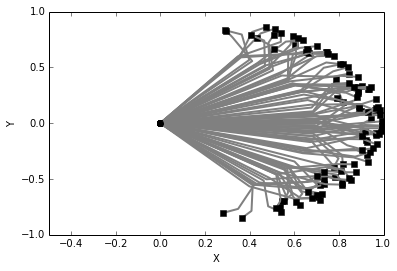

In [4]:
%pylab inline
ax = axes()

for m in random_motors:
    environment.plot_arm(ax, m)

Using a flow of sensorimotor experience, that is a flow of $(m, s)$ pairs (motor configuration associated with the corresponding observed sensory effect), we want to iteratively learn a sensorimotor model of this low-dimensional arm, which will be able to:
* infer the position of the end-effector from a given motor command, what is called forward prediction,
* infer the motor command allowing to reach a particular end-effector position, what is called inverse prediction.


Similarly to environments, available sensorimotor models in Explauto can be accessed using:

In [5]:
from explauto.sensorimotor_model import sensorimotor_models
print 'Available sensorimotor models: {}'.format(sensorimotor_models.keys())

Available sensorimotor models: ['ilo_gmm', 'LWLR-CMAES', 'WNN', 'NN', 'LWLR-BFGS']


Here we will use the 'nearest_neighbor' model. This sensorimotor model simply stores sensorimotor experience, ie. $(m, s)$ pairs where $m$ are motor commands (here arm joint positions) and $s$ are the corresponding sensory effects (here end-effector positions). When asked for a forward prediction for a given motor command $m$, it returns the associated sensory effect $s$ of the nearest neighbor of $m$ in the stored sensorimotor experience. When asked for an inverse prediction to reach a sensory goal $s$, it returns the associated motor command $m$ of the nearest neighbor of $s$ in the stored sensorimotor experience, possibly pertubated with a bit gaussian noise.

Let's have a look at the available configurations for the 'nearest_neighbor' model:

In [6]:
sm_cls, sm_configs = sensorimotor_models['NN']
print 'Available configurations for the nearest_neighbor model: {}'.format(sm_configs.keys())

Available configurations for the nearest_neighbor model: ['default']


We will use the 'exact' configuration, which perform forward and inverse prediction as explained above, without any noise added (ie., it just looks for the nearest neighbor). 

Now we can instantiate the sensorimotor model by using:

In [7]:
model = sm_cls(environment.conf, **sm_configs['default'])

Note that in addition to the configuration keyword arguments, one also has to pass environment.conf. This a [Configuration](http://flowersteam.github.io/explauto/explauto.utils.html#explauto.utils.config.Configuration) object which is instantiated during the environment creation and provides information about the motor and sensorimotor ranges used in the environment. It is useful for the sensorimotor model to be properly configured. When using the 'default' configuration for example, the added noise when performing inverse prediction depends on the motor ranges. Passing environment.conf thus allows to define sensorimotor model configurations independently of particular environment settings.

Note that instead of the previous lines, one can equivalently use this shortcut in order to instantiate the sensorimotor model (similarly to the [Environment.from_configuration](http://flowersteam.github.io/explauto/explauto.environment.html#explauto.environment.environment.Environment.from_configuration) class method we used above):

In [8]:
from explauto import SensorimotorModel
model = SensorimotorModel.from_configuration(environment.conf, 'NN', 'default')

Now let's train the model from the execution of random motor commands (that we already have stored above in random_motors):

In [9]:
for m in random_motors:
    s = environment.compute_sensori_effect(m)  # compute the sensori effect s of the motor command m through the environment
    model.update(m, s)

Note that sensorimotor model training in Explauto is an iterative process. They incorporate new sensorimotor experience on the fly instead that using batch training. This is a requirement for autonomous exploration where the internal model has to be refined *online*.

Once the sensorimodel has been trained, one can perform forward and inverse prediction with it. Let's predict the sensori effect of a new random motor command (which is not in the training set we just used) using the [forward_prediction](http://flowersteam.github.io/explauto/explauto.sensorimotormodel.html#explauto.sensorimotor_model.sensorimotor_model.SensorimotorModel.forward_prediction) method:

In [10]:
m = environment.random_motors(n=1)[0, :]
s_pred = model.forward_prediction(m)
print 'random motor command: ', m
print 'predicted effect: ', s_pred

random motor command:  [-0.46366971 -0.1944862  -0.98022953]
predicted effect:  [ 0.84742199 -0.49255655]


and compare the predicted effect with the real effect observed from executing $m$ through the environment:

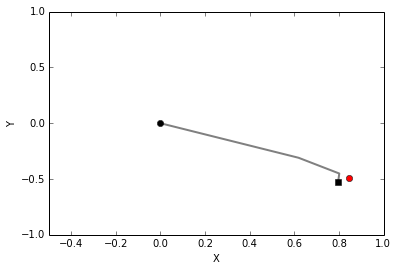

In [11]:
ax = axes()
environment.plot_arm(ax, m)
ax.plot(*s_pred, marker='o', color='red')

We observe that the predicted end-effector position is quite close to the observed position when executing the motor command. Using the 'nearest_neighbor' model, it simply corresponds to the sensory effect of the nearest neighbor of $m$ in the stored sensorimotor experience.

Sensorimotor models can also be used for inverse prediction using the [inverse_prediction](http://flowersteam.github.io/explauto/explauto.sensorimotormodel.html#explauto.sensorimotor_model.sensorimotor_model.SensorimotorModel.inverse_prediction) method, allowing the inference of an appropriate motor comand $m$ in order to reach a given sensory goal $s_g$:

In [12]:
s_g = [0.7, 0.5]
m = model.inverse_prediction(s_g)
print 'Inferred motor command to reach the position ', s_g, ': ', m

Inferred motor command to reach the position  [0.7, 0.5] :  [ 0.52913744  0.88143033 -0.6860698 ]


We can check if the inferred motor command is actually appropriate to reach the goal $s_g$:

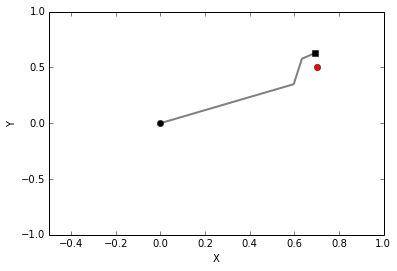

In [13]:
ax = axes()
environment.plot_arm(ax, m)
ax.plot(*s_g, marker='o', color='red')

We observe that the inferred motor command results in an end-effector position which is quite close to the goal. Using the 'exact' configuration of the 'nearest_neighbor' model, it is simply the motor command which resulted in the sensory effect which is the closest to $s_g$ in the stored experience.

## Exercises

Use the sensorimotor model we just trained to follow a straight line with the end-effector from point $A=[0.8, 0.5]$ to point $B=[0.8, -0.5]$.

In [ ]:
%load exercise_solutions/learning_sensorimotor_models__follow_line.py

if the result is not satisfactory, continue to train the model with more random points (eg.: 10000) an try again.

In [ ]:
%load exercise_solutions/learning_sensorimotor_models__more_training.py